### Bioneuron Oracle Notebook
#### Peter Duggins
#### April 2017
#### https://github.com/psipeter/bioneuron_oracle

This notebook includes methods for specifying weights into an emsemble of biologically realistic neurons such that it performs representation and dynamics according to the NEF. These 'bioneurons' are implemented in NEURON based off of a reduced model of a pyramidal neuron by Bahl et al (2012). It begins by defining a bioneuron class that includes the NEURON objects needed to track voltage, spikes, etc, as well as the required nengo methods to run in simulation. It then redefines some classes in the nengo builder to allow construction of bioensembles and transmission of spikes to the bioneurons' synapses. During the build, synapses are created at specified locations on the bioneurons' dendrites, and are assigned a synaptic weight that has been decomposed into encoders and decoders. Whereas previous bioneuron methods trained the enoders, this notebook seeks to distribute encoders randomly in a manner that ensures heterogeneity of bioneuron response curves, then trains decoders using NEF methods such as the least-squares solver or Aaron Voelker's Oracle. It then provides tests for the efficacy of these procedures by finding the error in the bioensemble's decoded output for various choices of encoder, decoder, and dynamical system.

### Install NEURON and other dependencies
change --prefix to another directory. If you're using virtualenv and virtualenvwrapper, this will be your your /HOME/USER/.local/directory

```bash
pip install nengo matplotlib seaborn numpy pandas

wget http://www.neuron.yale.edu/ftp/neuron/versions/v7.4/nrn-7.4.tar.gz
tar xzf nrn-7.4.tar.gz
cd nrn-7.4
./configure --prefix=/home/$USER/.local --without-iv --with-nrnpython
make
(sudo) make install
cd src/nrnpython
python setup.py install
cd ../../..
```

### Install channel mechanisms for the bahl.hoc NEURON model
To run the NEURON model, bahl.hoc, you must download the .hoc file and .mod files for every ion channel present in the model. These come with the repo, but must be compiled with the NEURON you've just installed locally.

Be sure to change the path to your .local directory to compile the NEURON channel mechanisms.

```bash
git clone https://github.com/psipeter/bioneuron_oracle.git
cd bioneuron_oracle/NEURON_models/channels/
/home/$USER/.local/x86_64/bin/nrnivmodl
```

The first line of `../bahl.hoc` points NEURON towards the location of these compiled channel files:
```
nrn_load_dll("./channels/x86_64/.libs/libnrnmech.so")
```

If this doesn't work, try giving the full path:
```
nrn_load_dll("PATH_TO_REPO/bioneuron_oracle/NEURON_models/channels/x86_64/.libs/libnrnmech.so")
```

If the python kernel crashes at some point and you get an error in the terminal that says "NEURON: syntax error [...] insert ih", it means that the channels weren't initialized properly.

# Bioneuron Methods
### Define bioneuron class

In [373]:
%matplotlib inline
import nengo
import numpy as np
import neuron
import os
import warnings

# EDIT this to point to your local repository for Jupyter notebook
neuron.h.load_file('/home/pduggins/bioneuron_oracle/NEURON_models/bahl.hoc')
# For the library
# neuron.h.load_file(os.path.abspath(os.path.join(
#     os.path.dirname(__file__),"NEURON_models/bahl.hoc")))

class BahlNeuron(nengo.neurons.NeuronType):
    """Compartmental neuron from Bahl et al 2012."""

    probeable=('spikes', 'voltage')
    def __init__(self,):
        super(BahlNeuron,self).__init__()
            
    def rates(self, x, gain, bias):
#         raise NotImplementedError
        return x

    def gain_bias(self, max_rates, intercepts):
        return np.ones(len(max_rates)),np.ones(len(max_rates))

    def step_math(self, dt, spiked, neurons, voltage, time):
        """
        Run NEURON forward one nengo timestep.
        Compare the current and previous spike arrays for this bioneuron.
        If they're different, the neuron has spiked.
        """

        neuron.run(time*1000)
        for i, nrn in enumerate(neurons):
            count = len(nrn.spikes) - nrn.num_spikes_last
            volt = np.array(nrn.v_record)[-1] # first call neuron.init()
            nrn.num_spikes_last = len(nrn.spikes)
            spiked[i] = count / dt
            voltage[i] = volt
        
class Bahl(object):
    def __init__(self):
        super(Bahl,self).__init__()
        self.synapses = {}
        self.cell = neuron.h.Bahl()
        self.v_record = neuron.h.Vector()
        self.v_record.record(self.cell.soma(0.5)._ref_v)
        self.ap_counter = neuron.h.APCount(self.cell.soma(0.5))
        self.t_record = neuron.h.Vector()
        self.t_record.record(neuron.h._ref_t)
        self.spikes = neuron.h.Vector()
        self.ap_counter.record(neuron.h.ref(self.spikes))
        self.num_spikes_last = 0
        
class ExpSyn(object):
    """
    Conductance-based synapses.
    There are two types, excitatory and inhibitory,
    with different reversal potentials. 
    If the synaptic weight is above zero, initialize an excitatory synapse, 
    else initialize an inhibitory syanpse with abs(weight).
    """
    
    def __init__(self, sec, weight, tau, e_exc=0.0, e_inh=-80.0):
        self.tau = tau
        self.e_exc = e_exc
        self.e_inh = e_inh
        self.syn = neuron.h.ExpSyn(sec)
        self.syn.tau = 1000*self.tau  # no more 2x multiply
        self.weight = weight
        if self.weight >= 0.0: self.syn.e = self.e_exc
        else: self.syn.e = self.e_inh
        # time of spike arrival assigned in nengo step
        self.spike_in = neuron.h.NetCon(None, self.syn)
        self.spike_in.weight[0]=abs(self.weight)

### Nengo Operators and Builders

In [374]:
import nengo
import numpy as np
import neuron
from nengo.builder import Builder, Operator, Signal
from nengo.dists import get_samples
from nengo.builder.connection import build_decoders
from nengo.builder.connection import BuiltConnection
from nengo.builder.ensemble import get_activities
# from BahlNeuron import BahlNeuron, Bahl, ExpSyn

class SimBahlNeuron(Operator):
    """
    Operator to simulate the states of a bioensemble through time.
    """

    def __init__(self, neuron_type, n_neurons, output, voltage, states):
        super(SimBahlNeuron, self).__init__()
        self.neuron_type = neuron_type
        self.reads = [states[0]]
        self.sets = [output, voltage]
        self.updates = []
        self.incs = []
        self.neuron_type.neurons = [Bahl() for _ in range(n_neurons)]
        # self.inputs stores the input decoders, connection weights, 
        # synaptic locations, and synaptic filter (tau)
        # for each connection into bionrn
        self.inputs = {}

    def make_step(self, signals, dt, rng):
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(dt,output,self.neuron_type.neurons,voltage,time)
        return step_nrn
    
    @property
    def time(self):
        return self.reads[0]
    
    @property
    def output(self):
        return self.sets[0]

    @property
    def voltage(self):
        return self.sets[1]


class TransmitSpikes(Operator):
    """
    Operator to deliver spikes from the presynaptic population
    into a bioensemble.
    """
    
    def __init__(self, ens_pre, ens_post, neurons, spikes, states):
        super(TransmitSpikes, self).__init__()
        self.ens_pre = ens_pre
        self.ens_post = ens_post
        self.neurons = neurons
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        
    @property
    def spikes(self):
        return self.reads[0]
        
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            t_neuron = (time-dt)*1000
            for n in range(spikes.shape[0]): #for each input neuron
                num_spikes = int(spikes[n]*dt + 1e-9) # TODO: untested
                for _ in range(num_spikes):
                    for nrn in self.neurons: #for each bioneuron
                        for syn in nrn.synapses[self.ens_pre][n]: #for each synapse conn. to input
                            syn.spike_in.event(t_neuron) #add a spike at time (ms)
        return step

from nengo import Connection as NengoConnection
from nengo.solvers import LstsqL2
__all__ = ['Connection']  # what does this do?

class BioConnection(NengoConnection):
    """
    Extends nengo.Connection to take additional parameters
    and support oracle decoder updating
    """
    def __init__(self, pre, post, solver=LstsqL2(), 
                 syn_sec={'apical'},  n_syn=1,
                 weights_bias_conn=True, bio_decoders=None, **kwargs):
        """
        syn_sec: the section(s) of the NEURON model on which to distribute synapses
        n_syn: number of synapses on the bioneuron per presynaptic neuron
        weight_bias_conn: (bool) use this connection to emulate bioneuron biases
        """
#         self.pre = pre
#         self.post = post
#         self.solver = solver
        self.syn_sec = syn_sec
        self.n_syn = n_syn
        self.weights_bias_conn = weights_bias_conn
        self.bio_decoders = bio_decoders
        super(BioConnection, self).__init__(pre, post, solver=solver, **kwargs)  # todo: recursion depth error

    
@Builder.register(BahlNeuron)
def build_bahlneuron(model, neuron_type, ens):
    model.sig[ens]['voltage'] = Signal(np.zeros(ens.ensemble.n_neurons),
        name='%s.voltage' %ens.ensemble.label)
    op = SimBahlNeuron(neuron_type = neuron_type,
                        n_neurons = ens.ensemble.n_neurons,
                        output = model.sig[ens]['out'],
                        voltage = model.sig[ens]['voltage'],
                        states = [model.time])
    # Initialize specific encoders and gains, if this hasn't already been done
    # todo: should this go in build_bahlneuron() or SimBahlNeuron() instead?
    if not hasattr(ens.ensemble, 'encoders') or not isinstance(ens.ensemble.encoders, np.ndarray):
        encoders, gains = gen_encoders_gains(
            ens.ensemble.n_neurons, ens.ensemble.dimensions, ens.ensemble.seed)
        ens.ensemble.encoders = encoders
        ens.ensemble.gains = gains
    model.add_op(op)

@Builder.register(nengo.Connection)
def build_connection(model,conn):
    """
    Method to build connections into bioensembles.
    Calculates the optimal decoders for this conneciton as though the presynaptic ensemble 
    was connecting to a hypothetical LIF ensemble. These decoders are used to calculate
    the synaptic weights in init_connection().
    Adds a transmit_spike operator for this connection to the model
    """
    conn_into_bioneuron = (
        isinstance(conn.post, nengo.Ensemble) and
        isinstance(conn.post.neuron_type, BahlNeuron))
    if hasattr(conn.pre,'neuron_type'):
        conn_out_bioneuron = (
            isinstance(conn.pre.neuron_type, BahlNeuron) and
            isinstance(conn.post, nengo.Ensemble))
    else:
        conn_out_bioneuron = False
        
    if conn_into_bioneuron:
        # conn.pre must output spikes to connect to bioneurons
        assert (hasattr(conn.pre, 'neuron_type')),\
            "input %s to bioensemble %s must transmit spikes" %(conn.pre, conn.post)
        assert ('spikes' in conn.pre.neuron_type.probeable),\
            "input %s to bioensemble %s must transmit spikes"%(conn.pre, conn.post)
        # Todo: other error handling
        rng = np.random.RandomState(model.seeds[conn])
        model.sig[conn]['in'] = model.sig[conn.pre]['out']
        transform = get_samples(conn.transform, conn.size_out,
                                d=conn.size_mid, rng=rng)
         
        """
        Given a parcicular connection, labeled by id(conn.pre),
        compute the optimal decoders, generate locations for synapses,
        then create a synapse with weight equal to
        w_ij=np.dot(d_i,alpha_j*e_j)+w_bias, where 
            - d_i is the optimal presynaptic decoder,
            - e_j is the single bioneuron encoder
            - w_bias is a weight perturbation that emulates bias
        Afterwards add synapses to bioneuron.synapses and call neuron.init().
        """
        conn.syn_loc = get_synaptic_locations(
            rng, conn.pre.n_neurons, conn.post.n_neurons, 
            conn.syn_sec, conn.n_syn, seed=model.seeds[conn])
        conn.syn_weights = np.zeros((
            conn.post.n_neurons, conn.pre.n_neurons, conn.syn_loc.shape[2]))
        # emulated biases in weight space
        if conn.weights_bias_conn: 
            conn.weights_bias = gen_weights_bias(
                conn.pre.n_neurons, conn.post.n_neurons, conn.pre.dimensions,
                conn.post.dimensions, conn.pre.seed, conn.post.seed)
            
        for bionrn in range(len(conn.post.neuron_type.neurons)):
            bioneuron = conn.post.neuron_type.neurons[bionrn]
            d_in = weights.T  # untested for BIO-BIO connections
            loc = conn.syn_loc[bionrn]
            if hasattr(conn,'weights_bias'):  
                w_bias = conn.weights_bias[:,bionrn]
            tau = conn.synapse.tau
            encoder = conn.post.encoders[bionrn]
            gain = conn.post.gains[bionrn]
            bioneuron.synapses[id(conn.pre)] = np.empty((loc.shape[0],loc.shape[1]),dtype=object)
            for pre in range(loc.shape[0]):
                for syn in range(loc.shape[1]):
                    section = bioneuron.cell.apical(loc[pre,syn])
                    w_ij = np.dot(d_in[pre],gain*encoder)
                    if hasattr(conn,'weights_bias'):  
                        w_ij += w_bias[pre]
                    w_ij /= conn.post.neuron_type.n_syn  # todo: better n_syn scaling
                    conn.syn_weights[bionrn,pre,syn] = w_ij  # update full weight matrix
                    synapse = ExpSyn(section,w_ij,tau)  # create the synapse
                    bioneuron.synapses[id(conn.pre)][pre][syn] = synapse            
        neuron.init()    
        
        model.add_op(TransmitSpikes(
            id(conn.pre), id(conn.post), conn.post.neuron_type.neurons,
            model.sig[conn.pre]['out'], states=[model.time]))
        # note: transform, weights do not affect X-to-BIO connections (todo: untested)
        model.params[conn] = BuiltConnection(eval_points=eval_points,
                                                solver_info=solver_info,
                                                transform=transform,
                                                weights=conn.syn_weights)

    if conn_out_bioneuron:
        rng = np.random.RandomState(model.seeds[conn])
        model.sig[conn]['in'] = model.sig[conn.pre]['out']
        transform = get_samples(conn.transform, conn.size_out,
                                d=conn.size_mid, rng=rng)
        # Update decoders out of bioensembles, presumably by using the Oracle method.
        eval_points, weights, solver_info = build_decoders(
            model, conn, rng, transform)
        if conn.bio_decoders is not None:
            #todo: error handing for correct shape
            weights = conn.bio_decoders
        model.params[conn] = BuiltConnection(eval_points=eval_points,
                                            solver_info=solver_info,
                                            transform=transform,
                                            weights=weights)
    else: #normal connection
        return nengo.builder.connection.build_connection(model, conn)

In [375]:
def gen_encoders_gains(n_neurons, dimensions, seed):
    """
    Alternative to gain_bias() for bioneurons.
    Called in custom build_connections().
    TODO: add max_rates and other scaling properties.
    """
    with nengo.Network() as pre_model:
        lif = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                                neuron_type=nengo.LIF(), seed=seed)
    with nengo.Simulator(pre_model) as pre_sim:
        encoders = pre_sim.data[lif].encoders
        gains = pre_sim.data[lif].gain
    return encoders, gains


def gen_weights_bias(pre_neurons, n_neurons, in_dim,
                        out_dim, pre_seed, bio_seed):

    """
    Build a pre-simulation network to draw biases from Nengo,
    then return a weight matrix that emulates the bias
    (by adding weights to the synaptic weights in init_connection().
    """

    with nengo.Network(label='preliminary') as pre_model:
        pre = nengo.Ensemble(n_neurons=pre_neurons, dimensions=in_dim,
                                seed=pre_seed)
        lif = nengo.Ensemble(n_neurons=n_neurons, dimensions=out_dim,
                                neuron_type=nengo.LIF(), seed=bio_seed)
    with nengo.Simulator(pre_model) as pre_sim:
        pre_activities = get_activities(pre_sim.data[pre], pre, 
                                        pre_sim.data[pre].eval_points)
        biases = pre_sim.data[lif].bias
    # Desired output function Y -- just repeat "bias" m times
    Y = np.tile(biases, (pre_activities.shape[0],1))
    solver = nengo.solvers.LstsqL2(reg=0.01)  # todo: test other solvers?
    weights_bias, info = solver(pre_activities,Y)
    return weights_bias


def get_synaptic_locations(rng, pre_neurons, n_neurons, syn_sec, n_syn, seed):
    # todo: syn_sec support
    # (return {section,syn_locations} and handle in build_connections)
    """Choose one:"""
    # todo: make syn_distribution an optional parameters of nengo.Connection
    # same locations per connection and per bioneuron
#     rng2=np.random.RandomState(seed=333)
#     syn_locations=np.array([rng2.uniform(0,1,size=(pre_neurons,n_syn))
#         for n in range(n_neurons)])
    # same locations per connection and unique locations per bioneuron
#     rng2=np.random.RandomState(seed=333)
#     syn_locations=rng2.uniform(0,1,size=(n_neurons,pre_neurons,n_syn))
    # unique locations per connection and per bioneuron (uses conn's rng)
    syn_locations=rng.uniform(0,1,size=(n_neurons,pre_neurons,n_syn))
    return syn_locations

__all__ = ['patch', 'unpatch']  # what does this do?
def patch_connections(connection=True):
    """Monkeypatches bioneuron connections into Nengo"""
    if connection:
        nengo.Connection = BioConnection

def unpatch_connections():
    nengo.Connection = NengoConnection

### Signals

In [376]:
import nengo
import numpy as np
import neuron

def prime_sinusoids(t, dim, t_final):
    # todo: generate primes
    primes=[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 
            47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101,
            103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 
            157, 163, 167, 173, 179, 181, 191, 193, 197, 199]
    our_primes=primes[:dim]
    t_per_dim=t_final/dim
    epoch=int(t/t_per_dim)
    reordered_primes=[our_primes[(p + epoch) % len(our_primes)] for p in range(len(our_primes))]
    frequencies=np.pi*np.array(reordered_primes)
    values = np.array([np.sin(w*t) for w in frequencies])
    return values

def step_input(t, dim, t_final, dt, n_eval_points=4):

    """
    Creates an (dim x n_eval_points) array where each row contains
    a uniform tiling from -1 to 1.
    To sample the dim-dimensional space, take every combination of values
    in this array.
    To do this, assume that each value is played for t_per_value time,
    and begin by taking eval_points[d,0] for each dimension.
    Then leave all but 1 dimension the same, and take 
    eval_points[dim,1] from that dimension.
    Repeat until all values of the d_last dimesion are sampled.
    Then take eval_points[d,0] for d=0...dim-1, eval_points[dim-1,1]
    for the 2nd to last dimension,and repeat recursively up the array.
    
    n_eval_points: number of evaluation points to sample for each dimension
    """

    n_vals=n_eval_points**dim
    n_times=int(t_final/dt)
    assert n_vals < n_times, "must be at least one timestep per constant value"
    t_per_val=int(n_times/n_vals)
    x_vals=np.linspace(-1,1,n_eval_points)
    eval_points=np.zeros((dim,n_eval_points))
    for d in range(dim):
        eval_points[d]=x_vals

    def get_eval_point(t,eval_points):
        t_idx=int(t/dt)
        idxs=np.zeros((dim)).astype(int)
        for d in range(dim):
            idxs[d]=int(t_idx / t_per_val / (n_eval_points ** d)) % n_eval_points
        return [eval_points[d,idxs[d]] for d in range(dim)]

    return np.array(get_eval_point(t,eval_points))

In [377]:
prime_sinusoids(np.pi/2,3,2*np.pi)

array([-0.43030122,  0.78553281, -0.44280997])

In [378]:
step_input(t=0.123,dim=2,t_final=1.0,dt=0.001,n_eval_points=10)

array([-0.55555556, -0.77777778])

# Feedforward Unit Test

In [379]:
import nengo
import numpy as np
import neuron
# from BahlNeuron import BahlNeuron, Bahl, ExpSyn
# from custom_signals import prime_sinusoids, step_input
from nengo.utils.matplotlib import rasterplot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def feedforward(pre_neurons, bio_neurons, tau_nengo, tau_neuron, dt_nengo, 
                dt_neuron, pre_seed, bio_seed, t_final, dim, signal, 
                decoders_bio=None, plots={'spikes','voltage','decode'}):
    """
    Simulate a feedforward network [stim]-[LIF]-[BIO]
    and compare to [stim]-[LIF]-[LIF].
    
    signal: 'prime_sinusoids' or 'step_input'
    decoders_bio: decoders for [BIO]-[probe] from a previous simulation
    """

    with nengo.Network() as model:
        patch_connections()

        if signal == 'prime_sinusoids':
            stim = nengo.Node(lambda t: prime_sinusoids(t, dim, t_final))
        elif signal == 'step_input':
            stim = nengo.Node(lambda t: step_input(t, dim, t_final, dt_nengo))

        pre = nengo.Ensemble(n_neurons=pre_neurons, dimensions=dim,
                            seed=pre_seed, neuron_type=nengo.LIF())
        bio = nengo.Ensemble(n_neurons=bio_neurons, dimensions=dim, 
                            seed=bio_seed, neuron_type=BahlNeuron())
        lif = nengo.Ensemble(n_neurons=bio_neurons, dimensions=dim, 
                            neuron_type=nengo.LIF(), seed=bio_seed)
        direct = nengo.Ensemble(n_neurons=1, dimensions=dim, 
                                neuron_type=nengo.Direct(),)

        nengo.Connection(stim,pre,synapse=None)
        nengo.Connection(pre,bio,synapse=tau_neuron)
        nengo.Connection(pre,lif,synapse=tau_nengo)
        nengo.Connection(stim,direct,synapse=tau_nengo)

        probe_stim = nengo.Probe(stim,synapse=None)
        probe_pre = nengo.Probe(pre,synapse=tau_nengo)
        probe_lif = nengo.Probe(lif,synapse=tau_nengo)
        probe_direct = nengo.Probe(direct,synapse=tau_nengo)
        probe_pre_spikes = nengo.Probe(pre.neurons,'spikes')
        probe_bio_spikes = nengo.Probe(bio.neurons,'spikes')
        probe_lif_spikes = nengo.Probe(lif.neurons,'spikes')
        
    with nengo.Simulator(model,dt=dt_nengo) as sim:
        patch_connections()

        sim.run(t_final)
        
    sns.set(context='poster')
    if 'spikes' in plots:
        '''spike raster for PRE, BIO and comparison LIF ensembles'''
        figure, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
        rasterplot(sim.trange(),sim.data[probe_pre_spikes],ax=ax1,
                    use_eventplot=True)
        ax1.set(ylabel='pre',yticks=([]))
        rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax2,
                    use_eventplot=True)
        ax2.set(ylabel='bioneuron',yticks=([]))
        rasterplot(sim.trange(),sim.data[probe_lif_spikes],ax=ax3,
                    use_eventplot=True)
        ax3.set(xlabel='time (s)',ylabel='lif') #,yticks=([])

    if 'voltage' in plots:
        '''voltage trace for a specific bioneuron'''
        figure2, ax3 = plt.subplots(1, 1, sharex=True)
        bio_idx = 0
        neuron = bio.neuron_type.neurons[bio_idx]
        ax3.plot(np.array(neuron.t_record),np.array(neuron.v_record))
        ax3.set(xlabel='time (ms)', ylabel='Voltage (mV)')

    if 'decode' in plots:
        '''decoded output of bioensemble'''
        figure3, ax4 = plt.subplots(1,1,sharex=True)
        lpf = nengo.Lowpass(tau_nengo)
        solver = nengo.solvers.LstsqL2(reg=0.01)
        act_bio = lpf.filt(sim.data[probe_bio_spikes], dt=dt_nengo)
        if decoders_bio==None:
            decoders_bio, info = solver(act_bio, sim.data[probe_direct])
        xhat_bio=np.dot(act_bio,decoders_bio)
        rmse_bio=np.sqrt(np.average((
            sim.data[probe_direct]-xhat_bio)**2))
        rmse_lif=np.sqrt(np.average((
            sim.data[probe_direct]-sim.data[probe_lif])**2))
        ax4.plot(sim.trange(),xhat_bio,label='bio, rmse=%.5f'%rmse_bio)
        ax4.plot(sim.trange(),sim.data[probe_lif],
            label='lif, rmse=%.5f'%rmse_lif)
        ax4.plot(sim.trange(),sim.data[probe_direct],label='direct')
        ax4.set(ylabel='$\hat{x}(t)$')#,ylim=((ymin,ymax)))
        legend3=ax4.legend() #prop={'size':8}
    plt.show()
    
    # todo: call NEURON garbage collection
    return decoders_bio

Single encoder per bioneuron; includes gains and biases; multiple dimensions and synapses per connection; decoders computed from the bioneurons' activities and the ideal system output (direct mode).

In [380]:
pre_neurons=100
bio_neurons=50
tau_nengo=0.01
tau_neuron=0.01
dt_nengo=0.001
dt_neuron=0.0001
pre_seed=3
bio_seed=6
t_final=1.0
dim=2
n_syn=5
signal='prime_sinusoids'
decoders_bio=None
plots={'spikes','voltage','decode'}

d_1 = feedforward(pre_neurons, bio_neurons, tau_nengo, tau_neuron, dt_nengo, 
                dt_neuron, pre_seed, bio_seed, t_final, dim, signal, 
                decoders_bio, plots)

RuntimeError: maximum recursion depth exceeded

### Random Decoders

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   


/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'gains' on '<Ensemble (unlabeled) at 0x7f2f081ff9d0>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'syn_loc' on '<Connection from <Ensemble (unlabeled) at 0x7f2f06126c90> to <Ensemble (unlabeled) at 0x7f2f081ff9d0>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'syn_weights' on '<Connection from <Ensemble (unlabeled) at 0x7f2f06126c90> to <Ensemble (unlabeled) at 0x7f2f081ff9d0>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'weights_b

Building finished in 0:00:01.                                                   
Simulating finished in 0:02:23.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:82: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


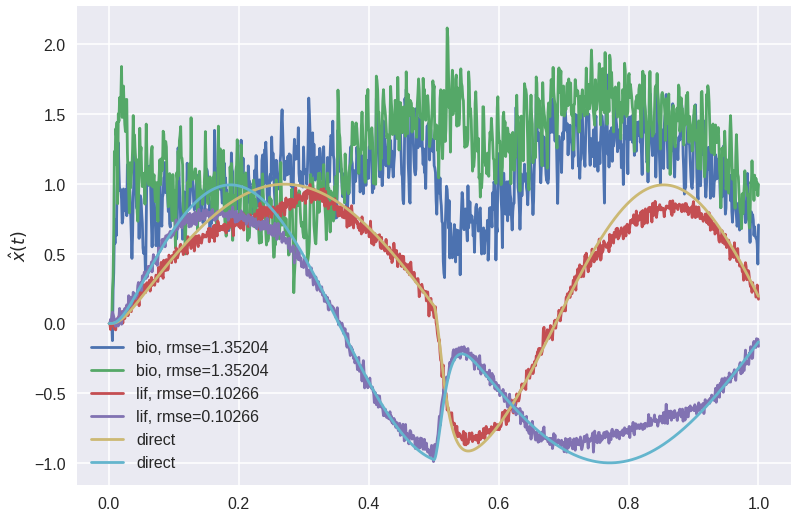

In [195]:
pre_neurons=100
bio_neurons=50
tau_nengo=0.01
tau_neuron=0.01
dt_nengo=0.001
dt_neuron=0.0001
pre_seed=3
bio_seed=6
t_final=1.0
dim=2
n_syn=5
signal='prime_sinusoids'
d_random=np.random.RandomState(seed=123).uniform(np.min(d_1),np.max(d_1),size=d_1.shape)
plots={'decode'}

d_2 = feedforward(pre_neurons, bio_neurons, tau_nengo, tau_neuron, dt_nengo, 
                dt_neuron, pre_seed, bio_seed, t_final, dim, signal, 
                d_random, plots)

### Change the LIF input (seed) but decode with original decoders

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   


/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'gains' on '<Ensemble (unlabeled) at 0x7f2f05caa810>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'syn_loc' on '<Connection from <Ensemble (unlabeled) at 0x7f2f061a5550> to <Ensemble (unlabeled) at 0x7f2f05caa810>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'syn_weights' on '<Connection from <Ensemble (unlabeled) at 0x7f2f061a5550> to <Ensemble (unlabeled) at 0x7f2f05caa810>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'weights_b

Building finished in 0:00:01.                                                   
Simulating finished in 0:02:20.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:82: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


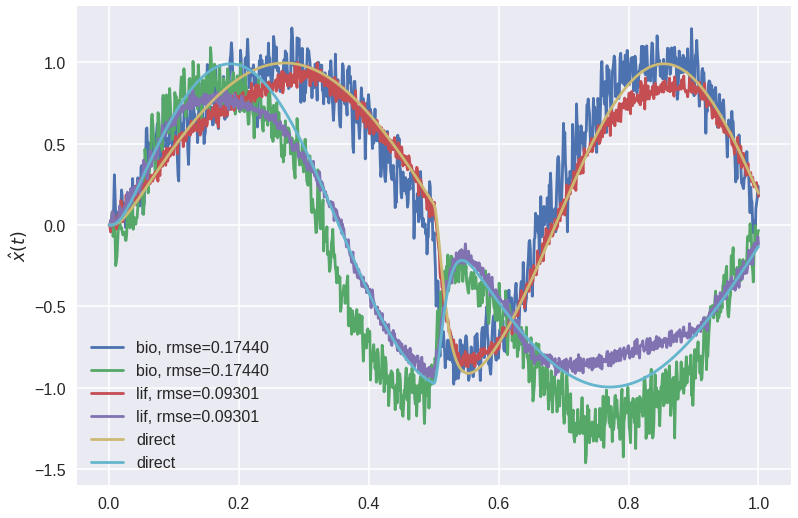

In [196]:
pre_neurons=100
bio_neurons=50
tau_nengo=0.01
tau_neuron=0.01
dt_nengo=0.001
dt_neuron=0.0001
pre_seed=9
bio_seed=6
t_final=1.0
dim=2
n_syn=5
signal='prime_sinusoids'
decoders_bio=d_1
plots={'decode'}

d_3 = feedforward(pre_neurons, bio_neurons, tau_nengo, tau_neuron, dt_nengo, 
                dt_neuron, pre_seed, bio_seed, t_final, dim, signal, 
                d_1, plots)

### New LIF (seed), new signal, old decoders

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   


/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'gains' on '<Ensemble (unlabeled) at 0x7f2f05167d90>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'syn_loc' on '<Connection from <Ensemble (unlabeled) at 0x7f2f051673d0> to <Ensemble (unlabeled) at 0x7f2f05167d90>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'syn_weights' on '<Connection from <Ensemble (unlabeled) at 0x7f2f051673d0> to <Ensemble (unlabeled) at 0x7f2f05167d90>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'weights_b

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:09.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:82: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


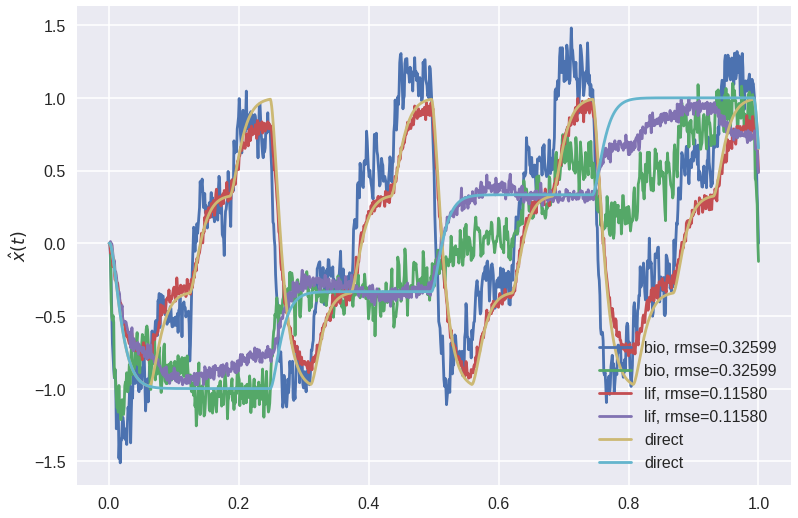

In [201]:
pre_neurons=100
bio_neurons=50
tau_nengo=0.01
tau_neuron=0.01
dt_nengo=0.001
dt_neuron=0.0001
pre_seed=9
bio_seed=6
t_final=1.0
dim=2
n_syn=5
signal='step_input'
decoders_bio=d_1
plots={'decode'}

d_4 = feedforward(pre_neurons, bio_neurons, tau_nengo, tau_neuron, dt_nengo, 
                dt_neuron, pre_seed, bio_seed, t_final, dim, signal, 
                d_1, plots)

# Multi-input, Multi-output Unit Test

In [101]:
import nengo
import numpy as np
import neuron
# from BahlNeuron import BahlNeuron, Bahl, ExpSyn
# from custom_signals import prime_sinusoids, step_input
from nengo.utils.matplotlib import rasterplot
import matplotlib.pyplot as plt
import seaborn as sns

def mutli_input_output(pre_neurons, bio_neurons, post_neurons, tau_nengo, tau_neuron,
                dt_nengo, dt_neuron, pre_seed, bio_seed, post_seed, t_final, dim, 
                oracle_decoders=None, w_train=0, jl_dims=0, 
                plots={'spikes','voltage','decode'}):
    """
    Simulate a network [stim1]-[LIF1]-[BIO]-[LIF3]
                        [stim2]-[LIF2]-[BIO]-[LIF4]
    oracle_decoders: decoders out of [BIO] that are trained by the oracle method (iterative)
    w_train: soft-mux parameter that governs what fraction of [BIO]-out decoders are computed
                randomly vs from the oracle method
    jl_dims: extra dimensions for the oracle training (Johnson–Lindenstrauss lemma)
    """

    if oracle_decoders == None:
        oracle_decoders = np.zeros((bio_neurons,dim))
        
    with nengo.Network() as model:

        stim1 = nengo.Node(lambda t: 0.5*prime_sinusoids(t, 2*dim, t_final)[:dim])
#         stim2 = nengo.Node(lambda t: 0.5*prime_sinusoids(t, 2*dim, t_final)[dim:2*dim])

        lif1 = nengo.Ensemble(n_neurons=pre_neurons, dimensions=dim,
                            seed=pre_seed, neuron_type=nengo.LIF())
#         lif2 = nengo.Ensemble(n_neurons=pre_neurons, dimensions=dim,
#                             seed=2*pre_seed, neuron_type=nengo.LIF())
        bio = nengo.Ensemble(n_neurons=bio_neurons, dimensions=dim, 
                            seed=bio_seed, neuron_type=BahlNeuron(lif1,n_syn))
        lif3 = nengo.Ensemble(n_neurons=post_neurons, dimensions=dim, 
                            neuron_type=nengo.LIF(), seed=post_seed)
#         lif4 = nengo.Ensemble(n_neurons=post_neurons, dimensions=dim, 
#                             neuron_type=nengo.LIF(), seed=2*post_seed)
        direct_eq = nengo.Ensemble(n_neurons=1, dimensions=dim,
                                 neuron_type=nengo.Direct())
        direct3 = nengo.Ensemble(n_neurons=1, dimensions=dim,
                                 neuron_type=nengo.Direct())
#         direct4 = nengo.Ensemble(n_neurons=1, dimensions=dim,
#                                  neuron_type=nengo.Direct())

        nengo.Connection(stim1,lif1,synapse=None)
#         nengo.Connection(stim2,lif2,synapse=None)
        nengo.Connection(lif1,bio,synapse=tau_neuron)
#         nengo.Connection(lif2,bio,synapse=tau_neuron)
        conn3 = nengo.Connection(bio,lif3,synapse=tau_neuron,transform=[[w_train]])
#         conn4 = nengo.Connection(bio,lif4,synapse=tau_neuron)
        nengo.Connection(stim1,direct_eq,synapse=tau_nengo)
#         nengo.Connection(stim2,direct_eq,synapse=tau_nengo)
        nengo.Connection(direct_eq,direct3,synapse=tau_nengo)
#         nengo.Connection(direct_eq,direct4,synapse=tau_nengo)

        probe_stim1 = nengo.Probe(stim1,synapse=None)
#         probe_stim2 = nengo.Probe(stim2,synapse=None)
        probe_lif1 = nengo.Probe(lif1,synapse=tau_nengo)
#         probe_lif2 = nengo.Probe(lif2,synapse=tau_nengo)
        probe_lif3 = nengo.Probe(lif3,synapse=tau_nengo)
#         probe_lif4 = nengo.Probe(lif4,synapse=tau_nengo)
        probe_direct3 = nengo.Probe(direct3,synapse=tau_nengo)
#         probe_direct4 = nengo.Probe(direct4,synapse=tau_nengo)
        probe_bio_spikes = nengo.Probe(bio.neurons,'spikes')
        probe_bio = nengo.Probe(bio,)
    
        conn3.oracle_decoders = (1 - w_train)*oracle_decoders  # HACK
#         if jl_dims > 0:
#             # TODO: magnitude should scale with n_neurons somehow (maybe 1./n^2)?
#             jl_decoders = np.random.RandomState(seed=333).randn(n_neurons, jl_dims) * 1e-4
#             conn.oracle_decoders = np.hstack((conn.oracle_decoders, jl_decoders))
        
    with nengo.Simulator(model,dt=dt_nengo) as sim:
        sim.run(t_final)
        
    assert np.count_nonzero(sim.data[probe_bio] > 1.0/dt_nengo) == 0
    lpf = nengo.Lowpass(tau_nengo)
    act_bio = lpf.filt(sim.data[probe_bio_spikes], dt=dt_nengo)
    y = sim.data[probe_direct3]
    solver = nengo.solvers.LstsqL2(reg=0.1)
    oracle_decoders, info = solver(act_bio, y)
    y_hat = np.dot(act_bio, oracle_decoders)
    
    sns.set(context='poster')
    if 'spikes' in plots:
        '''spike raster for BIO ensemble'''
        figure, ax1 = plt.subplots(1, 1, sharex=True)
        rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax1,
                    use_eventplot=True)
        ax1.set(ylabel='bioneuron',yticks=([]))
    if 'voltage' in plots:
        '''voltage trace for a specific bioneuron'''
        figure2, ax1 = plt.subplots(1, 1, sharex=True)
        bio_idx = 0
        neuron = bio.neuron_type.neurons[bio_idx]
        ax1.plot(np.array(neuron.t_record),np.array(neuron.v_record))
        ax1.set(xlabel='time (ms)', ylabel='Voltage (mV)')
    if 'decode' in plots:
        '''decoded output of lif3 and lif4'''
        figure3, (ax3, ax4) = plt.subplots(2,1,sharex=True)
        rmse_lif3 = np.sqrt(np.average((
            sim.data[probe_direct3]-sim.data[probe_lif3])**2))
#         rmse_lif4 = np.sqrt(np.average((
#             sim.data[probe_direct4]-sim.data[probe_lif4])**2))
        ax3.plot(sim.trange(),sim.data[probe_lif3],
            label='lif, rmse=%.5f'%rmse_lif3)
        ax3.plot(sim.trange(),sim.data[probe_direct3],label='direct3')        
#         ax4.plot(sim.trange(),sim.data[probe_lif4],
#             label='lif, rmse=%.5f'%rmse_lif4)
#         ax4.plot(sim.trange(),sim.data[probe_direct4],label='direct4')
        ax3.set(ylabel='$\hat{x}(t)$')#,ylim=((ymin,ymax)))
#         ax4.set(ylabel='$\hat{x}(t)$')#,ylim=((ymin,ymax)))
        legend3=ax3.legend() #prop={'size':8}
#         legend4=ax4.legend() #prop={'size':8}
    plt.show()
    
    print 'weights used in this simulation', sim.data[conn3].weights
    print 'oracle decoders to be used in next simulation', oracle_decoders
#     print sim.data[conn4].weights
    # todo: call NEURON garbage collection
    
    return oracle_decoders

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   


/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'oracle_decoders' on '<Connection from <Ensemble (unlabeled) at 0x7fd1873e09d0> to <Ensemble (unlabeled) at 0x7fd1873e0a10>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'gains' on '<Ensemble (unlabeled) at 0x7fd1873e09d0>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'syn_loc' on '<Connection from <Ensemble (unlabeled) at 0x7fd186bbc110> to <Ensemble (unlabeled) at 0x7fd1873e09d0>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'syn_w

build connection weights [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


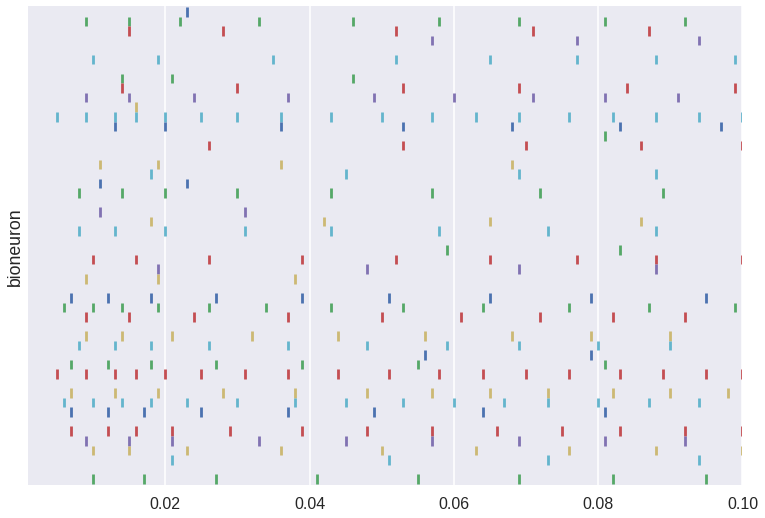

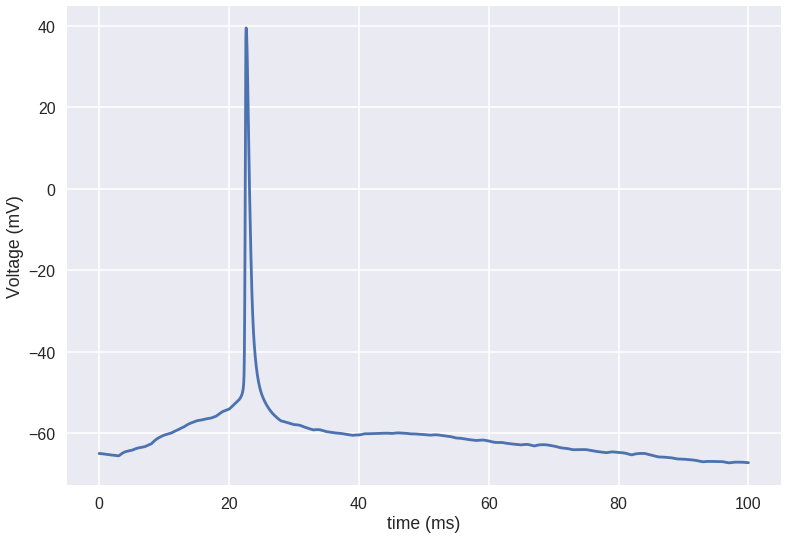

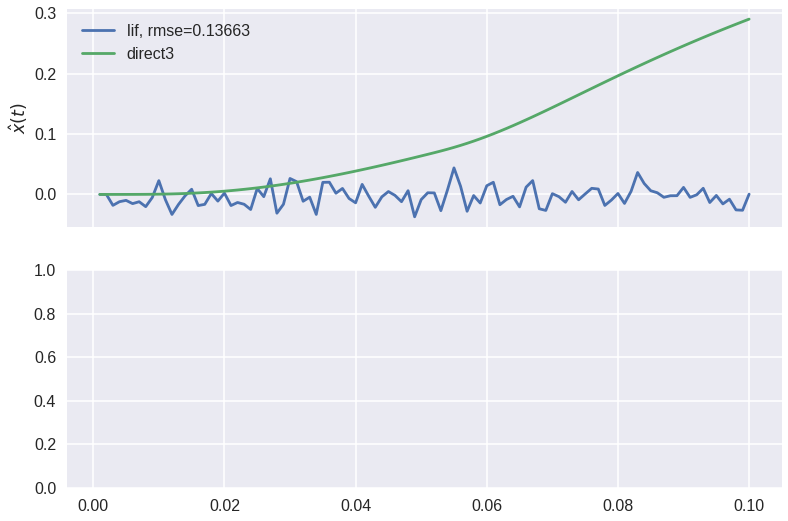

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ -1.32903236e-04]
 [  4.60670642e-05]
 [ -2.52713428e-05]
 [  3.68578905e-04]
 [  0.00000000e+00]
 [  2.14615791e-04]
 [  0.00000000e+00]
 [ -3.69367648e-04]
 [  7.68983617e-05]
 [  1.38636314e-04]
 [ -1.63430040e-04]
 [  2.62303962e-05]
 [  1.11009756e-04]
 [  4.12301907e-04]
 [  1.52124782e-04]
 [  0.00000000e+00]
 [ -2.08961912e-04]
 [  2.05564780e-04]
 [ -1.46716457e-04]
 [ -1.32265022e-04]
 [  0.00000000e+00]
 [ -1.18501113e-04]
 [  1.83490902e-04]
 [ -6.07978157e-05]
 [  0.00000000e+00]
 [  1.53407103e-04]
 [  3.07664683e-05]
 [  1.09135648e-04]
 [ -2.83861949e-04]
 [  0.00000000e+00]
 [  5.87670119e-06]
 [ -7.74647877e-05]
 [  1.45656675e-04]
 [  0.00000000e+00]
 [  7.99653945e-05]
 [ -3.29870190e-05]
 [  6.40622473e-05]
 [ -2.65337858e-04]
 [  1.33707598e-04]
 [  0.000000

/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'oracle_decoders' on '<Connection from <Ensemble (unlabeled) at 0x7fd1870ddf90> to <Ensemble (unlabeled) at 0x7fd1861b1d50>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'gains' on '<Ensemble (unlabeled) at 0x7fd1870ddf90>'. Did you mean to change an existing attribute?
  SyntaxWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'syn_loc' on '<Connection from <Ensemble (unlabeled) at 0x7fd18707e250> to <Ensemble (unlabeled) at 0x7fd1870ddf90>>'. Did you

build connection weights [[ -1.32903236e-04   4.60670642e-05  -2.52713428e-05   3.68578905e-04
    0.00000000e+00   2.14615791e-04   0.00000000e+00  -3.69367648e-04
    7.68983617e-05   1.38636314e-04  -1.63430040e-04   2.62303962e-05
    1.11009756e-04   4.12301907e-04   1.52124782e-04   0.00000000e+00
   -2.08961912e-04   2.05564780e-04  -1.46716457e-04  -1.32265022e-04
    0.00000000e+00  -1.18501113e-04   1.83490902e-04  -6.07978157e-05
    0.00000000e+00   1.53407103e-04   3.07664683e-05   1.09135648e-04
   -2.83861949e-04   0.00000000e+00   5.87670119e-06  -7.74647877e-05
    1.45656675e-04   0.00000000e+00   7.99653945e-05  -3.29870190e-05
    6.40622473e-05  -2.65337858e-04   1.33707598e-04   0.00000000e+00
    2.39629218e-04   1.20284884e-04  -2.78561821e-04   0.00000000e+00
    1.10837419e-04  -1.33619819e-05   5.43916372e-05   1.24659518e-04
    0.00000000e+00   1.06507016e-04]]
Building finished in 0:00:01.                                                   
Simulating finis

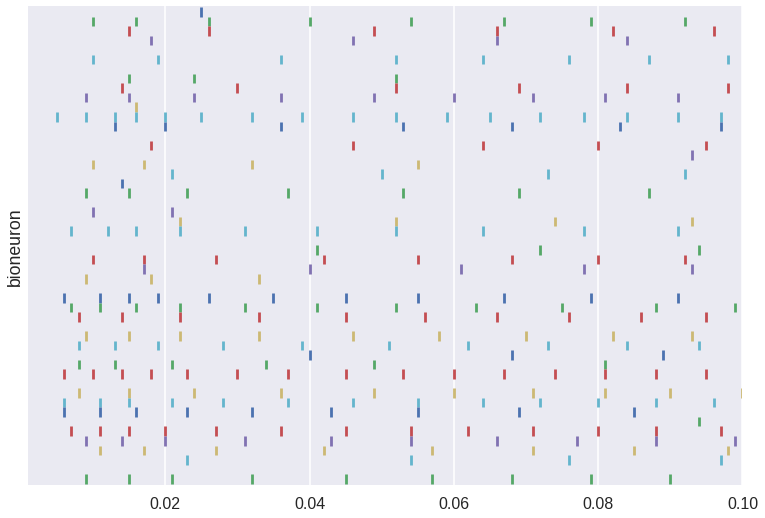

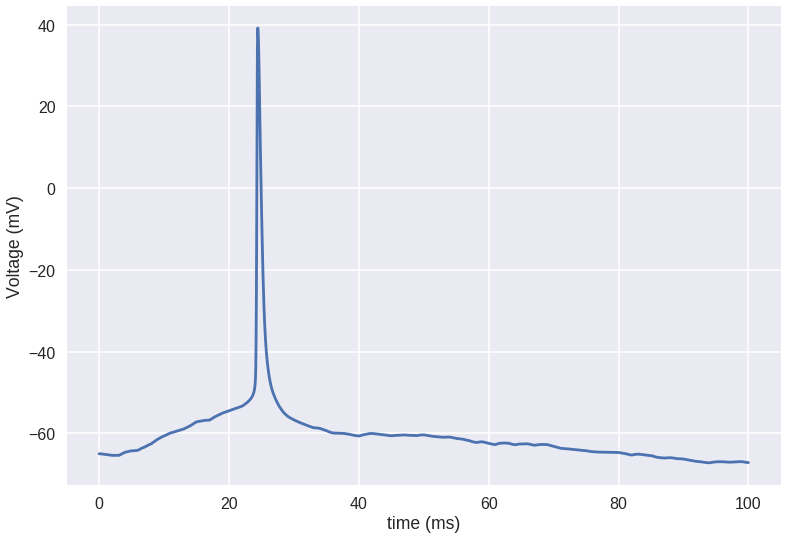

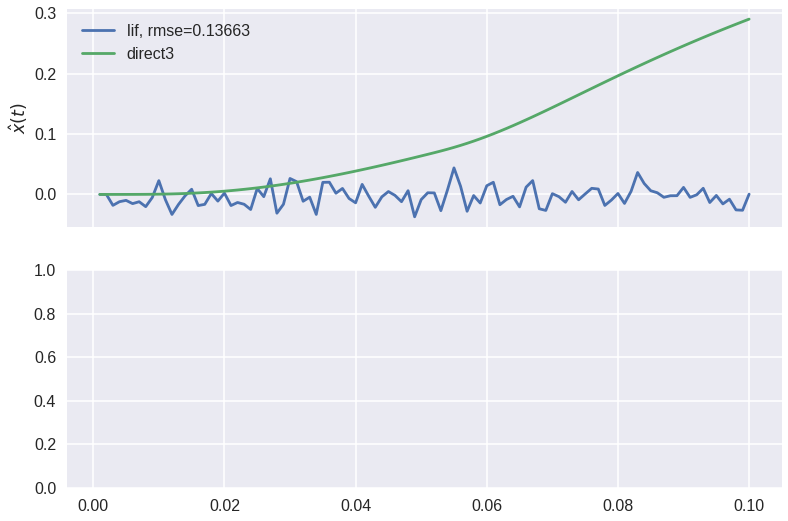

[[ -1.32903236e-04   4.60670642e-05  -2.52713428e-05   3.68578905e-04
    0.00000000e+00   2.14615791e-04   0.00000000e+00  -3.69367648e-04
    7.68983617e-05   1.38636314e-04  -1.63430040e-04   2.62303962e-05
    1.11009756e-04   4.12301907e-04   1.52124782e-04   0.00000000e+00
   -2.08961912e-04   2.05564780e-04  -1.46716457e-04  -1.32265022e-04
    0.00000000e+00  -1.18501113e-04   1.83490902e-04  -6.07978157e-05
    0.00000000e+00   1.53407103e-04   3.07664683e-05   1.09135648e-04
   -2.83861949e-04   0.00000000e+00   5.87670119e-06  -7.74647877e-05
    1.45656675e-04   0.00000000e+00   7.99653945e-05  -3.29870190e-05
    6.40622473e-05  -2.65337858e-04   1.33707598e-04   0.00000000e+00
    2.39629218e-04   1.20284884e-04  -2.78561821e-04   0.00000000e+00
    1.10837419e-04  -1.33619819e-05   5.43916372e-05   1.24659518e-04
    0.00000000e+00   1.06507016e-04]]
[[ -1.61390139e-04]
 [  6.83751102e-05]
 [  1.26225498e-04]
 [  5.52761620e-05]
 [  0.00000000e+00]
 [  2.79062013e-04]
 [

In [100]:
pre_neurons=100
bio_neurons=50
post_neurons=100
tau_nengo=0.01
tau_neuron=0.01
dt_nengo=0.001
dt_neuron=0.0001
pre_seed=3
bio_seed=6
post_seed=9
t_final=0.1
dim=1
n_syn=1
oracle_decoders=None
w_trains=[1.0,0.0]
plots={'spikes','voltage','decode'}

for w_train in w_trains:
    d_new = mutli_input_output(pre_neurons, bio_neurons, post_neurons, tau_nengo, tau_neuron,
                    dt_nengo, dt_neuron, pre_seed, bio_seed, post_seed, t_final, dim, 
                    oracle_decoders, w_train, plots)
    oracle_decoders = d_new

It seems as though the oracle_decoders are updating the weights into the bioneurons (unique spike patterns), but the decode from lif3 remains identical.

# Testing Postsynaptic Response TODO
We want to make sure that (a) spikes are successfully delivered using the above functions, and (b) that the induced postsynaptic response aligns with the lowpass synaptic in nengo for a chosen $\tau$.

In [153]:
def feedforward_tau_comparison(n_neurons, tau_nengo, tau_NEURON, dim, n_syn,
                               dt, t_final, encoders, gains, w_bias_from,
                               pre_seed, bio_seed,plots={}):

    with nengo.Network() as model:
        stim = nengo.Node(lambda t: prime_sinusoids(t,dim,t_final))
        pre=nengo.Ensemble(n_neurons=100,dimensions=dim,label='pre',seed=pre_seed)
        bio=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,label='bio',seed=bio_seed,
                           neuron_type=BahlNeuron(encoders,gains,w_bias_from))
        lif=nengo.Ensemble(n_neurons=n_neurons, dimensions=dim,
                           neuron_type=nengo.LIF(), label='lif', seed=bio_seed)
        direct=nengo.Ensemble(n_neurons=1,dimensions=dim,neuron_type=nengo.Direct(),label='direct')

        nengo.Connection(stim,pre,synapse=None)
        nengo.Connection(pre,bio,synapse=tau_NEURON)
        nengo.Connection(pre,lif,synapse=tau_nengo)
        nengo.Connection(stim,direct,synapse=tau_nengo)

        probe_stim=nengo.Probe(stim,synapse=None)
        probe_pre=nengo.Probe(pre,synapse=tau_nengo)
        probe_lif=nengo.Probe(lif,synapse=tau_nengo)
        probe_direct=nengo.Probe(direct,synapse=tau_nengo)
        probe_pre_spikes=nengo.Probe(pre.neurons,'spikes')
        probe_bio_spikes=nengo.Probe(bio.neurons,'spikes')
        probe_lif_spikes=nengo.Probe(lif.neurons,'spikes')
        
    with nengo.Simulator(model,dt=dt) as sim:
        sim.run(t_final)
        
    sns.set(context='poster')
    if 'spikes' in plots:
        '''spike raster for PRE, BIO and comparison LIF ensembles'''
        figure, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
        rasterplot(sim.trange(),sim.data[probe_pre_spikes],ax=ax1,use_eventplot=True)
        ax1.set(ylabel='pre',yticks=([]))
        rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax2,use_eventplot=True)
        ax2.set(ylabel='bioneuron',yticks=([]))
        rasterplot(sim.trange(),sim.data[probe_lif_spikes],ax=ax3,use_eventplot=True)
        ax3.set(xlabel='time (s)',ylabel='lif') #,yticks=([])

    if 'voltage' in plots:
        '''voltage trace for a specific bioneuron'''
        figure2,ax3=plt.subplots(1,1,sharex=True)
        bio_idx=0
        neuron=bio.neuron_type.father_op.neurons.neurons[bio_idx]
        ax3.plot(dt*np.arange(0,len(np.array(neuron.v_record))),np.array(neuron.v_record))
        ax3.set(xlabel='time (ms)', ylabel='Voltage (mV)')

    if 'decode' in plots:
        '''decoded output of bioensemble'''
        figure3,ax4=plt.subplots(1,1,sharex=True)
        lpf = nengo.Lowpass(tau)
        solver = nengo.solvers.LstsqL2(reg=0.01)
        decoders_bio, info = solver(
                                lpf.filt(sim.data[probe_bio_spikes], dt=dt),
                                lpf.filt(sim.data[probe_pre], dt=dt)) #one filter on target
        A_bio=lpf.filt(sim.data[probe_bio_spikes], dt=dt)
        xhat_bio=np.dot(A_bio,decoders_bio)
        rmse_bio=np.sqrt(np.average((sim.data[probe_direct]-xhat_bio)**2))
        rmse_lif=np.sqrt(np.average((sim.data[probe_direct]-sim.data[probe_lif])**2))
        ax4.plot(sim.trange(),xhat_bio,label='bio, rmse=%.5f'%rmse_bio)
        ax4.plot(sim.trange(),sim.data[probe_lif],label='lif, rmse=%.5f'%rmse_lif)
        ax4.plot(sim.trange(),sim.data[probe_direct],label='direct')
        ax4.set(ylabel='$\hat{x}(t)$')#,ylim=((ymin,ymax)))
        legend3=ax4.legend() #prop={'size':8}
    
    delete_bioneurons(bio)
    return decoders_bio

In [144]:
def postsynaptic_response_test(tau_nengo, tau_NEURON, dt, encoders, 
                               gains, w_bias_from, pre_seed, bio_seed, t_final):

    with nengo.Network() as model:
        # Run the model for t_transient so that bioneuron voltage settles to equilibrium
        # hardcoded signal shutoff when seeded pre spikes t=35
        stim = nengo.Node(lambda t: 0.75*(1000*dt<t<1035*dt))  

        pre=nengo.Ensemble(n_neurons=1, dimensions=1, label='pre', seed=pre_seed)
        bio=nengo.Ensemble(n_neurons=1, dimensions=1, label='bio', seed=bio_seed,
                           neuron_type=BahlNeuron(encoders,gains,w_bias_from))
        lif=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.LIF(), label='lif',
                           encoders=encoders, gain=gains, bias=bias)

        nengo.Connection(stim,pre,synapse=None)
        conn_bio=nengo.Connection(pre,bio,synapse=tau_NEURON)
        conn_lif=nengo.Connection(pre,lif.neurons,synapse=tau_nengo)

        probe_stim=nengo.Probe(stim,synapse=None)
        probe_pre_spikes=nengo.Probe(pre.neurons,'spikes')
        probe_lif_voltage=nengo.Probe(lif.neurons,'voltage')

    with nengo.Simulator(model,dt=dt) as sim:
        bioneuron=bio.neuron_type.father_op.neurons.neurons[0]
        bioneuron.v_syn_record=neuron.h.Vector()
        location=bioneuron.synapses['pre'][0][0].syn.get_loc() #does not contain section information
        bioneuron.v_syn_record.record(bioneuron.cell.apical(location)._ref_v)
        neuron.init()
        sim.run(t_final)

    t_pre_spikes=np.where(sim.data[probe_pre_spikes])[0]
    t_start_nengo=t_pre_spikes[0]*dt
    ts_nengo=sim.trange()
    ts_NEURON=np.array(bio.neuron_type.father_op.neurons.neurons[0].t_record)/1000
#     print 'conn weights', sim.data[conn_bio].weights, sim.data[conn_lif].weights

    voltage_nengo=50*sim.data[probe_lif_voltage]-70 #unscale LIF voltage: 50=delta V b/w rest, spike; -70=rest
    voltage_NEURON=np.array(bio.neuron_type.father_op.neurons.neurons[0].v_record)
    voltage_NEURON_syn=np.array(bio.neuron_type.father_op.neurons.neurons[0].v_syn_record)

    sns.set(context='poster')
    fig,ax=plt.subplots(1,1)
    ax.plot(ts_nengo,voltage_nengo,label='nengo.Lowpass')
    ax.plot(ts_NEURON,voltage_NEURON,label='BIO @ soma')
    ax.plot(ts_NEURON,voltage_NEURON_syn,label='BIO @ syanpse')
    # ax.plot(ts_nengo,sim.data[probe_pre_spikes]*0.01,label='pre spikes')
    # rasterplot(ts_nengo,sim.data[probe_pre_spikes],ax=ax,use_eventplot=True,label='pre_spikes') #messes us y-axis
    ax.set(xlim=((t_start_nengo-0.05,t_start_nengo+0.15)),ylim=((-70,-60)),xlabel='time (s)', ylabel='voltage (mV)')
    ax.legend()

### $\tau_{NEURON} = \tau_{nengo}$

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 
Building finished in 0:00:01.                                                   
Emulating bias from pre to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:22.                                                 


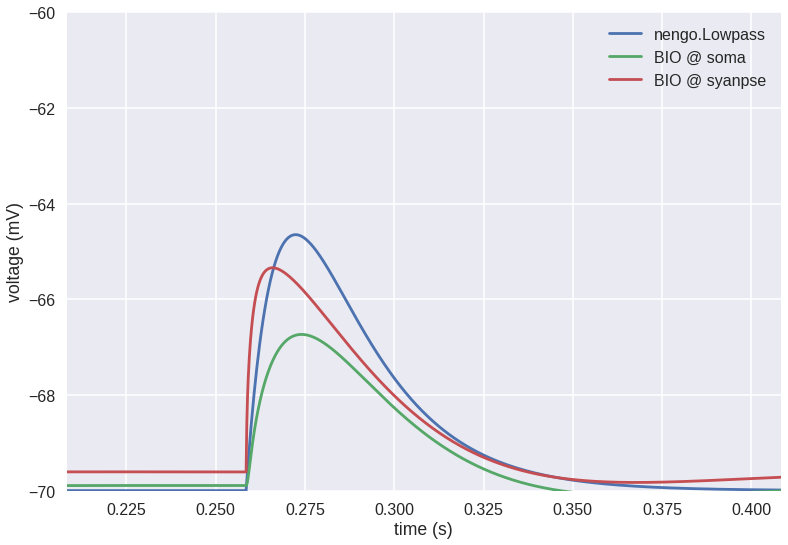

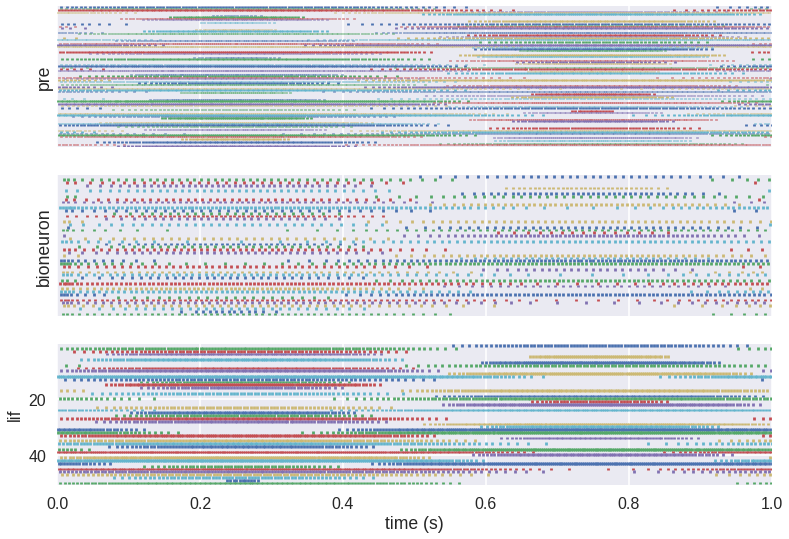

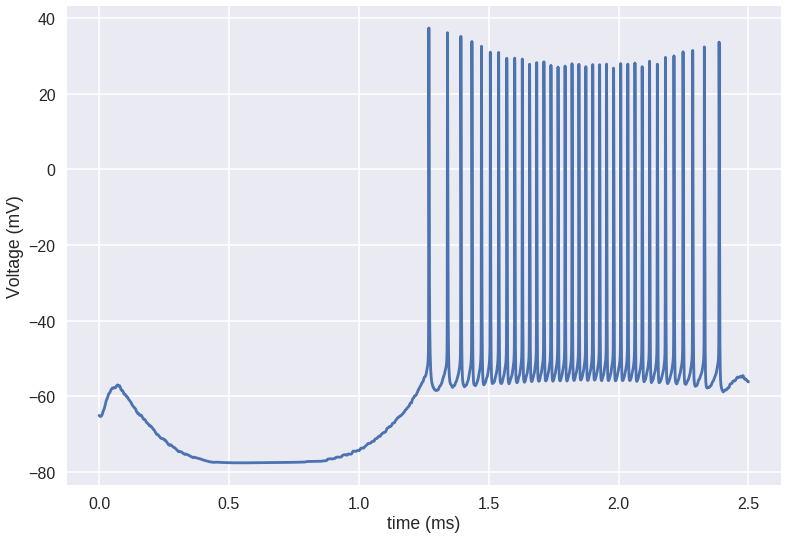

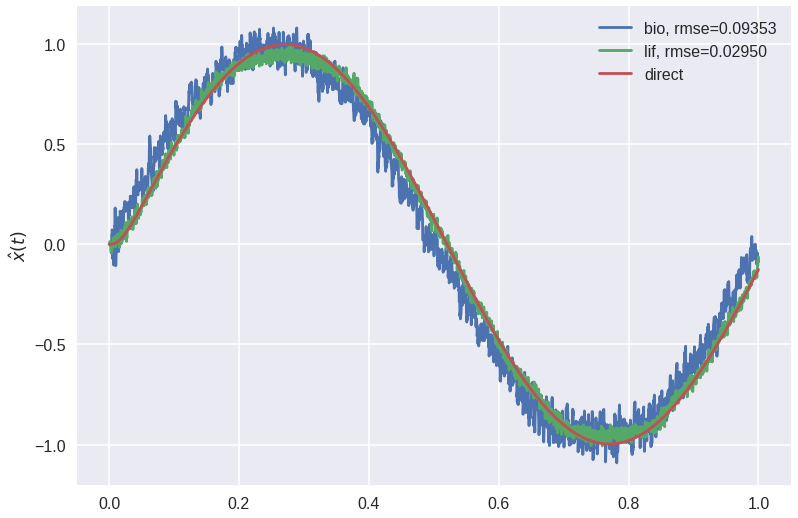

In [154]:
tau_nengo=0.01
tau_NEURON=tau_nengo
n_syn=1
dim=1
dt=0.00025
pre_seed=3
bio_seed=1
t_final=1.0

encoders=[[1]]
gains=[1]
bias=[0]
w_bias_from='None'

postsynaptic_response_test(tau_nengo, tau_NEURON, dt, encoders, 
                           gains, w_bias_from, pre_seed, bio_seed, t_final)

pre_neurons=100
n_neurons=50
pre_seed=3
bio_seed=6
w_bias_from='pre'

encoders, gains, weights_bias = gen_enc_gain_bias(
                                pre_neurons, n_neurons, tau,dim, n_syn, dt, t_final,
                                pre_seed, bio_seed, 'prime_sinusoids')

decoders_bio = feedforward_tau_comparison(n_neurons, tau_nengo, tau_NEURON, dim, n_syn,
                               dt, t_final, encoders, gains, w_bias_from,
                               pre_seed, bio_seed, plots={'spikes', 'voltage', 'decode'})

### $\tau_{NEURON} = 2*\tau_{nengo}$

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 
Building finished in 0:00:01.                                                   
Emulating bias from pre to bio
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:14.                                                 


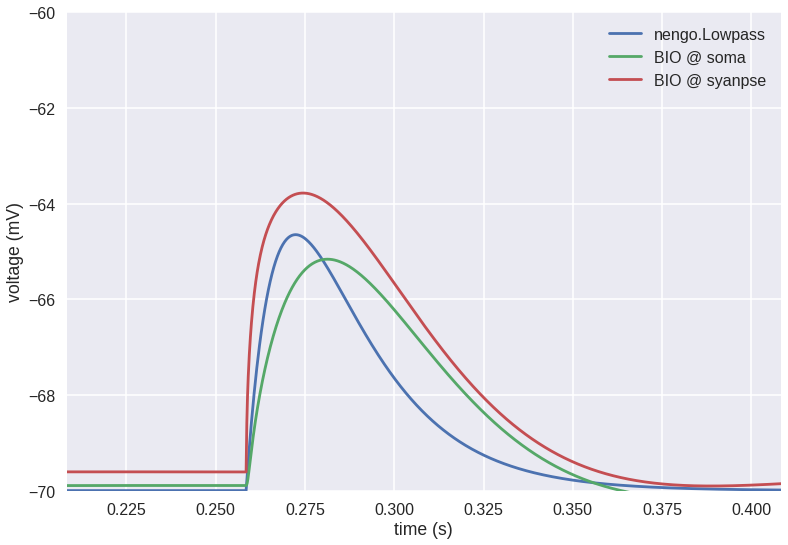

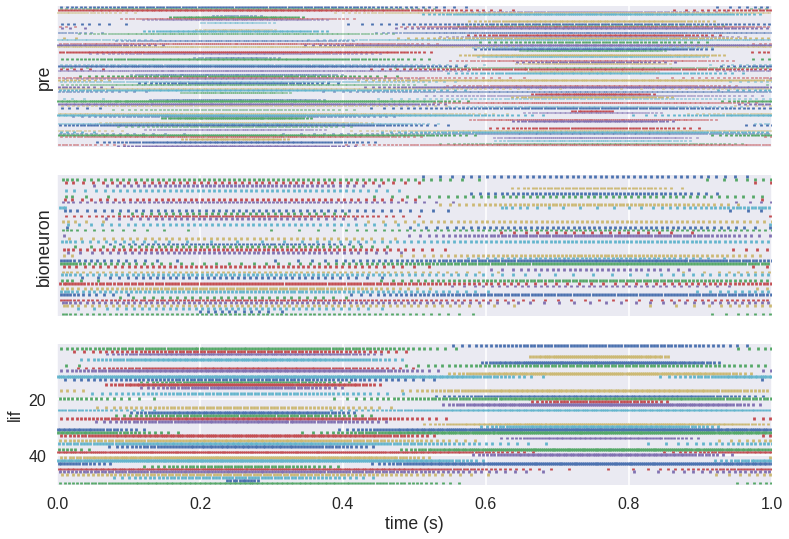

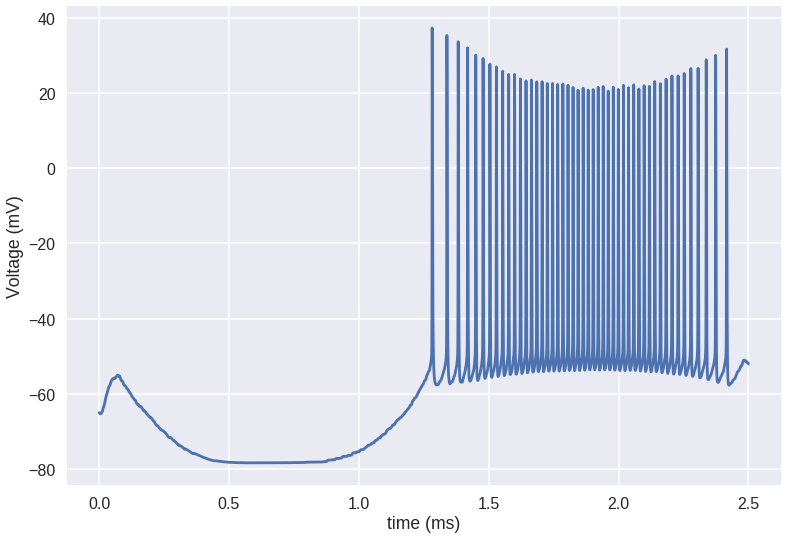

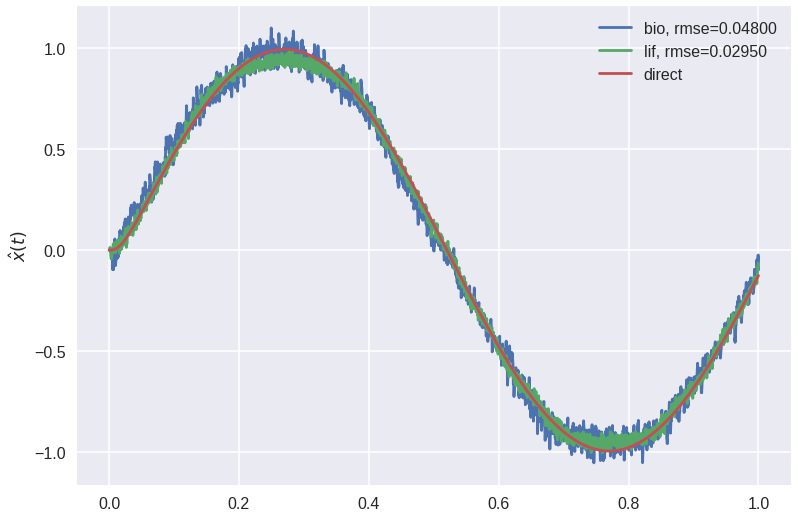

In [155]:
tau_nengo=0.01
tau_NEURON=2*tau_nengo
pre_seed=3
bio_seed=1
t_final=1.0

encoders=[[1]]
gains=[1]
bias=[0]
w_bias_from='None'

postsynaptic_response_test(tau_nengo, tau_NEURON, dt, encoders, gains, w_bias_from, pre_seed, bio_seed, t_final)

pre_neurons=100
n_neurons=50
pre_seed=3
bio_seed=6
w_bias_from='pre'

encoders, gains, weights_bias = gen_enc_gain_bias(
                                pre_neurons, n_neurons, tau,dim, n_syn, dt, t_final,
                                pre_seed, bio_seed, 'prime_sinusoids')

decoders_bio = feedforward_tau_comparison(n_neurons, tau_nengo, tau_NEURON, dim, n_syn,
                               dt, t_final, encoders, gains, w_bias_from,
                               pre_seed, bio_seed, plots={'spikes', 'voltage', 'decode'})

# Generate Tuning Curves

In [79]:
def tuning_curve_delta_rates(n_neurons,
                                tau,
                                dim,
                                n_syn,
                                dt,
                                encoders,
                                gains,
                                syn_locations,
                                weights_bias,
                                pre_seed,
                                bio_seed,
                                input_type,
                                n_eval_points=10,
                                decoders_bio=None,
                                plots={'tuning_bio'}):
    
    '''
    Simulates a [stim]-[LIF]-[BIO] network with an input U(t) that covers the state space,
    gathers the bioneurons' activities, and associates them with U(t) to produce tuning curves.
    
    input_type: a 'prime_sinusoid or 'step_input' signal for for each dimension
    decoders_bio: load in previously computed decoders out of [BIO] that will be used to find x_hat
    plots: dictionary of strings relating which plots to draw
    '''

    with nengo.Network() as model:
        if input_type == 'prime_sinusoids':
            stim = nengo.Node(lambda t: prime_sinusoids(t,dim,t_final))
        elif input_type == 'step_input':
            stim = nengo.Node(lambda t: step_input(t,dim,t_final,dt,n_eval_points))
        pre=nengo.Ensemble(n_neurons=100,dimensions=dim,label='pre',seed=pre_seed)
        bio=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,label='bio',seed=bio_seed,
                           neuron_type=BahlNeuron(encoders,gains,syn_locations,weights_bias))
        lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif')
        direct=nengo.Ensemble(n_neurons=1,dimensions=dim,neuron_type=nengo.Direct(),label='direct')

        nengo.Connection(stim,pre,synapse=None)
        nengo.Connection(pre,bio,synapse=tau)
        nengo.Connection(pre,lif,synapse=tau)
        nengo.Connection(stim,direct,synapse=tau)

        probe_stim=nengo.Probe(stim,synapse=None)
        probe_pre=nengo.Probe(pre,synapse=tau)
        probe_lif=nengo.Probe(lif,synapse=tau)
        probe_direct=nengo.Probe(direct,synapse=tau)
        probe_pre_spikes=nengo.Probe(pre.neurons,'spikes')
        probe_bio_spikes=nengo.Probe(bio.neurons,'spikes')
        probe_lif_spikes=nengo.Probe(lif.neurons,'spikes')
        
    with nengo.Simulator(model,dt=dt) as sim:
        sim.run(t_final)

    columns=('t_idx','x_dot_e','x_dot_e_bin','t','neuron','rate_bio','rate_lif')
    for d in range(dim):
        columns=columns+('x_%s'%d,)
    df=pd.DataFrame(columns=columns,index=np.arange(0,n_neurons*(sim.trange().shape[0]-1)))
    
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return array[idx]
        
    lpf=nengo.Lowpass(tau)
    delta_rates=np.zeros((n_neurons))
    print 'Constructing Pandas Dataframe...'
    j=0
    for bionrn in range(n_neurons):
        rates_bio=lpf.filt(sim.data[probe_bio_spikes][:,bionrn],dt=dt)
        rates_lif=lpf.filt(sim.data[probe_lif_spikes][:,bionrn],dt=dt)
        x_dot_e=np.dot(sim.data[probe_pre],encoders[bionrn])
        delta_rates[bionrn]=np.max(rates_bio)-np.min(rates_bio)
        x_dot_e_vals=np.linspace(np.min(x_dot_e),np.max(x_dot_e),num=n_eval_points)

        for t in np.arange(1,sim.trange().shape[0]):
            x_dot_e_bin=np.round(find_nearest(x_dot_e_vals,x_dot_e[t]),decimals=1)
            info=[t.astype(int),x_dot_e[t],x_dot_e_bin,t*dt,str(bionrn),rates_bio[t],rates_lif[t]]
            for d in range(dim):
                info.append(sim.data[probe_pre][t,d])
            df.loc[j]=info
            j+=1

    if 'stim' in plots:
        sns.set(context='poster')
        figure3,ax3=plt.subplots(1,1)
        ax3.plot(sim.trange(),sim.data[probe_stim])
        ax3.set(ylabel='stim')
    if 'spikes' in plots:
        figure2,ax2=plt.subplots(1,1)
        rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax2,use_eventplot=True)
        ax2.set(ylabel='bioneuron',yticks=([]))
    if '2d_heatmap' in plots:
        assert dim==2
        fig_heatmap,ax_heatmap=plt.subplots(1,1)
#         sns.jointplot('x_0','x_1',data=df,kind='kde',ax=ax_heatmap)
        heatmap=df.query('neuron=="1"').pivot('x_0','x_1','rate_bio')
        sns.heatmap(heatmap,ax=ax_heatmap)
        ax_heatmap.set(xlabel='$x_0$',ylabel='$x_1$',title='rates_bio')
    if 'tuning_bio' in plots:
        figure1,ax1=plt.subplots(1,1)
        sns.stripplot(x='x_dot_e_bin',y='rate_bio',hue='neuron',jitter=True,data=df)
        ax1.set(xlabel='$x . e_j$',ylabel='BIO firing rate (hz)')
    if 'tuning_lif' in plots:
        figure4,ax4=plt.subplots(1,1)
        sns.stripplot(x='x_dot_e_bin',y='rate_lif',hue='neuron',jitter=True,data=df)
        ax4.set(xlabel='$x . e_j$',ylabel='LIF firing rate (hz)')
                
    return np.array(delta_rates),df

While there are bioneurons whose min and max firing rate differ by less than the delta_rates_threshold, keep choosing new encoders and weights_bias for those.

Measure min and max rate in response to an input signal that is either sinusoidal (each dimension has a sinusoid with prime frequencies), or step inputs (ranging from x_min to x_max in each dimension). 

In [80]:
pre_neurons=100
n_neurons=5
tau=0.01
dim=2
n_syn=1
dt=0.001
t_final=10.0
n_eval_points=20
pre_seed=3
bio_seed=6
delta_rates_threshold=5
rng=np.random.RandomState(seed=333)
syn_locations=np.array([rng.uniform(0,1,size=(pre_neurons,n_syn)) for n in range(n_neurons)])


#first guess for bioneuron parameters
encoders, gains, weights_bias = gen_enc_gain_bias(
    pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

idx_unresponsive=np.arange(0,n_neurons) #array of bio_idx that don't cross rate threshold
while idx_unresponsive.shape[0] != 0:
    delta_rates,df=tuning_curve_delta_rates(
            n_neurons,tau,dim,n_syn,dt,encoders,gains,syn_locations,weights_bias,
            pre_seed,bio_seed,'prime_sinusoids',n_eval_points,decoders_bio=None,plots={'tuning_bio','tuning_lif'})
    idx_unresponsive=np.where(delta_rates<delta_rates_threshold)[0]
    print 'delta rates:', delta_rates
    for n in idx_unresponsive:
        encoders[n], gains[n], weights_bias[n] = gen_enc_gain_bias(
                    pre_neurons,1,tau,dim,n_syn,dt,t_final,rng.randint(336699),bio_seed,'prime_sinusoids')

decoders_bio_6=simulate(
    n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,syn_locations,weights_bias,
    pre_seed,bio_seed,'prime_sinusoids',plots={'decode'})

Building finished in 0:00:01.                                                   


TypeError: __init__() takes exactly 4 arguments (5 given)

It's hard to tell with the overlap in the tuning curve plots, but the bioneuron activities seem to vary smoothly with the encoded input $x . e_j$. This indicates that similar points in the state space are being mapped onto similar bioneuron responses.

### TODO: Figure out a nice seaborn method to plot tuning curves.
I can't figure out how to plot the tuning curves using sns.tsplot(), or even a time series using this function

In [ ]:
# n_neurons=5
# dim=2
# dt=0.001
# t_final=1.0
# n_eval_points=10
# pre_seed=3
# bio_seed=6
# rng=np.random.RandomState(seed=333)
# syn_locations=np.array([rng.uniform(0,1,size=(pre_neurons,n_syn)) for n in range(n_neurons)])

# encoders, gains, weights_bias = gen_enc_gain_bias(
#     pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed,'prime_sinusoids')

# delta_rates,df=tuning_curve_delta_rates(n_neurons,tau,dim,n_syn,dt,encoders,gains,syn_locations,weights_bias,
#                                         pre_seed,bio_seed,'prime_sinusoids',n_eval_points,
#                                         decoders_bio=None,plots={'tuning_bio','tuning_lif'})

# print df.loc[0]

# print (type(df.loc[0]['x_dot_e']),
# type(df.loc[0]['x_dot_e_bin']),
# type(df.loc[0]['t']),
# type(df.loc[0]['neuron']),
# type(df.loc[0]['rate_bio']),
# type(df.loc[0]['rate_lif']),
# type(df.loc[0]['x_0']),
# type(df.loc[0]['x_1']))

# figure1,ax1=plt.subplots(1,1)
# ax1.set(xlabel='$x . e_j$',ylabel='BIO firing rate (hz)')

# '''Throws unsupported operand type(s) for +: 'NoneType' and 'NoneType' '''
# # sns.tsplot(time="t",value="rate_bio",condition='neuron',data=df,ax=ax1) #how tsplot should be used
# # sns.tsplot(time="x_dot_e_bin",value="rate_bio",unit='t_idx',condition='neuron',data=df,ax=ax1)  #how I want to plot tuning curves

# #Matplotlib workaround
# # for bionrn in range(n_neurons):
# #     df_i=df.query('neuron=="%s"'%bionrn)
# #     x=df_i['x_dot_e_bin']
# #     y=df_i['rate_bio']
# #     ax1.plot(x,y,label=str(bionrn),marker='o',linestyle='')

# heatmap=df.query('neuron=="1"')
# print heatmap
# heatmap=heatmap.pivot('x_0','x_1','rate_bio')
# print heatmap
# sns.heatmap(heatmap)

# gammas = sns.load_dataset("gammas")

# gammas.loc[0]

# print (type(gammas.loc[0]['timepoint']),
# type(gammas.loc[0]['ROI']),
# type(gammas.loc[0]['subject']),
# type(gammas.loc[0]['BOLD signal']))

# figure1,ax1=plt.subplots(1,1)
# # sns.boxplot(x='x_dot_e_bin',y='rate_bio',hue='neuron',data=df)
# sns.tsplot(time="timepoint",value="BOLD signal",unit='subject',condition='ROI',data=gammas,ax=ax1)
# ax1.set(xlabel='$t$',ylabel='BOLD')

# flights = sns.load_dataset("flights")

# print flights

# flights = flights.pivot("month", "year", "passengers")

# flights